# Flopy Preprocessing Steps
- import libraries
- set file paths
- load input files
    - water surface elevation raster
    - ground water domain shapefile
    - left polyline boundary for floodplain
    - right polyline boundary for floodplain
- boundary conditions
    - water surface elevation raster converted to shapefile

In [ ]:
# make sure you're in virtual environment by running ".\\.venv\Scripts\activate" in terminal

In [ ]:
# Import libraries
import os
import flopy
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import rasterio
from rasterio.crs import CRS
from rasterio.transform import from_bounds
from rasterio.features import shapes
from shapely.geometry import shape
from shapely.geometry import Polygon  
from shapely.geometry import Point



In [ ]:
# Input Data
## Data Paths
water_surface_elevation_raster = r"C:\Users\RDEL1VMM\Documents\Python\test_12_18_2024\CH00365\GMS\WSE (Max).USGS_1m_FebApril2018_DEM.U_USGS-3DEP_dtm_hyrdo_flattened_20240412.2041_1.tif"
ground_water_domain_shapefile = r"C:\Users\RDEL1VMM\Documents\Python\test_12_18_2024\InputShapefiles\GWDomain.shp"
left_boundary_floodplain = r"C:\Users\RDEL1VMM\Documents\Python\test_12_18_2024\InputShapefiles\L_FPL.shp"
right_boundary_floodplain = r"C:\Users\RDEL1VMM\Documents\Python\test_12_18_2024\InputShapefiles\R_FPL.shp"

## Projection File Path
projection_file = r"C:\Users\RDEL1VMM\Documents\Python\test_12_18_2024\CH00365\RAS\GIS_Data\102739_TX_central.prj"

## Load Shapefiles
ground_water_domain = gpd.read_file(ground_water_domain_shapefile)
left_boundary = gpd.read_file(left_boundary_floodplain)
right_boundary = gpd.read_file(right_boundary_floodplain)

## Reproject Data to Match HEC-RAS CRS
hec_ras_crs = CRS.from_string(open(projection_file).read().strip())

## Reproject groundwater domain
ground_water_domain = ground_water_domain.to_crs(hec_ras_crs)

## Reproject left and right boundaries
left_boundary = left_boundary.to_crs(hec_ras_crs)
right_boundary = right_boundary.to_crs(hec_ras_crs)

In [ ]:
# Set up GeoDataFrame
# Open the raster file
with rasterio.open(water_surface_elevation_raster) as src:
    raster_array = src.read(1)  # Read the first band
    raster_transform = src.transform
    raster_crs = src.crs

# Initialize lists for polygons and values
polygons = []
values = []

# Iterate through the raster array
for i in range(raster_array.shape[0]):
    for j in range(raster_array.shape[1]):
        if not np.isnan(raster_array[i, j]):  # Process only valid pixels (no NaN)
            # Calculate polygon coordinates based on pixel position and raster transform
            x, y = raster_transform * (j, i)
            x_right, y_bottom = raster_transform * (j + 1, i + 1)

            polygon = Polygon([(x, y), (x_right, y), (x_right, y_bottom), (x, y_bottom)])
            polygons.append(polygon)
            values.append(raster_array[i, j])

# Create a GeoDataFrame from the polygons and values
converted_shapefile = gpd.GeoDataFrame({'value': values}, geometry=polygons, crs=raster_crs)

# Save the converted shapefile
output_shapefile = os.path.join(os.path.dirname(water_surface_elevation_raster), "converted_boundary_manual.shp")
converted_shapefile.to_crs(hec_ras_crs).to_file(output_shapefile)

print(f"Converted shapefile saved to: {output_shapefile}")

# Plot the converted shapefile
#converted_shapefile.plot(column="value", cmap="viridis", legend=True)
#plt.title("Converted Boundary Shapefile")
#plt.xlabel("Longitude")
#plt.ylabel("Latitude")
#plt.show()


Converted shapefile saved to: C:\Users\RDEL1VMM\Documents\Python\test_12_18_2024\CH00365\GMS\converted_boundary_manual.shp


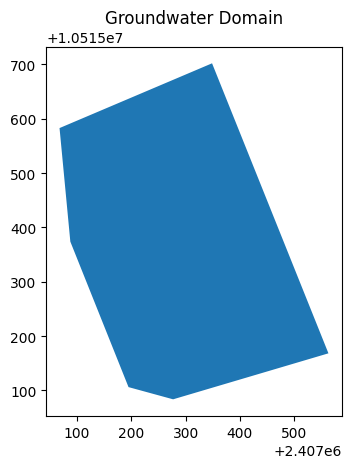

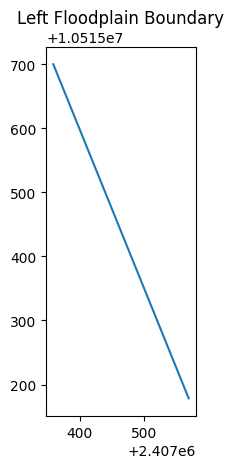

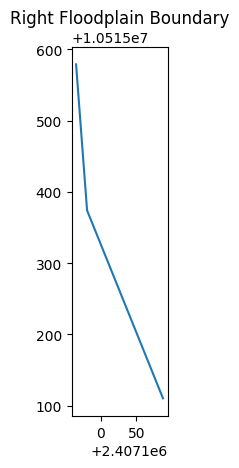

In [ ]:
# Visualize Groundwater Data
ground_water_domain.plot()
plt.title("Groundwater Domain")
plt.show()

left_boundary.plot()
plt.title("Left Floodplain Boundary")
plt.show()

right_boundary.plot()
plt.title("Right Floodplain Boundary")
plt.show()

## Setting up Model Grid

In [ ]:
# Define model name and executable path
model_name = "gwf_model"
exe_path = r"C:\Users\RDEL1VMM\Documents\Python\Flo_Py\flopy\modflowExe\mf6.exe"  # Update to your MODFLOW-2006 executable path
sim_name = "simple_test_sim"
workspace = "./modflow6_workspace"

# Create the simulation
sim = flopy.mf6.MFSimulation(sim_name=sim_name, exe_name=exe_path, sim_ws=workspace)

# Add temporal discretization (TDIS package)
tdis = flopy.mf6.ModflowTdis(
    sim, nper=1, perioddata=[(1.0, 1, 1.0)]  # 1 stress period, 1 time step
)

# Add IMS package (solver settings)
ims = flopy.mf6.ModflowIms(
    sim,
    print_option="SUMMARY",
    outer_dvclose=1e-6,
    outer_maximum=100,
    under_relaxation="NONE",
    inner_maximum=300,
    inner_dvclose=1e-6,
    rcloserecord=1e-6,
    linear_acceleration="CG",
    scaling_method="NONE",
    reordering_method="NONE",
    relaxation_factor=0.99,
)

# Create the GWF model
gwf = flopy.mf6.ModflowGwf(sim, modelname=model_name, model_nam_file=f"{model_name}.nam")



In [ ]:
# Model domain boundaries
# Get grid extent from groundwater domain
bounds = ground_water_domain.total_bounds  # [xmin, ymin, xmax, ymax]
cell_size_x, cell_size_y, cell_size_z = 10, 10, 10  # User-specified grid cell sizes

# Calculate grid size
ncol = int((bounds[2] - bounds[0]) / cell_size_x)  # Number of columns
nrow = int((bounds[3] - bounds[1]) / cell_size_y)  # Number of rows
top = 10.0  # Top elevation
botm = [0.0]  # Bottom elevation (1 layer)

# Create the DIS package
# Add spatial discretization
dis = flopy.mf6.ModflowGwfdis(
    gwf,
    nlay=1,
    nrow=nrow,
    ncol=ncol,
    delr=cell_size_x,
    delc=cell_size_y,
    top=top,
    botm=botm,
)

# Add initial conditions
ic = flopy.mf6.ModflowGwfic(gwf, strt=10.0)

# Add hydraulic properties
npf = flopy.mf6.ModflowGwfnpf(gwf, k=10.0, k33=10.0)

In [ ]:
# Create constant-head boundary conditions
grid_x, grid_y = np.meshgrid(
    np.linspace(bounds[0], bounds[2], ncol),
    np.linspace(bounds[3], bounds[1], nrow),
)
grid_points = [Point(x, y) for x, y in zip(grid_x.ravel(), grid_y.ravel())]

left_mask = np.zeros(len(grid_points), dtype=bool)
right_mask = np.zeros(len(grid_points), dtype=bool)

for poly in left_boundary.geometry:
    left_mask |= np.array([poly.contains(point) for point in grid_points])
for poly in right_boundary.geometry:
    right_mask |= np.array([poly.contains(point) for point in grid_points])

left_mask = left_mask.reshape(nrow, ncol)
right_mask = right_mask.reshape(nrow, ncol)

chd_data = []
for i in range(nrow):
    for j in range(ncol):
        if left_mask[i, j]:
            chd_data.append(((0, i, j), 10.0))  # Constant head on left boundary
        if right_mask[i, j]:
            chd_data.append(((0, i, j), 5.0))  # Constant head on right boundary

chd = flopy.mf6.ModflowGwfchd(
    gwf,
    stress_period_data={0: chd_data},
    pname="CHD",
)

# Add output control
oc = flopy.mf6.ModflowGwfoc(
    gwf,
    budget_filerecord=f"{model_name}.cbc",  # Budget file
    head_filerecord=f"{model_name}.hds",    # Head file
    saverecord=[("HEAD", "ALL"), ("BUDGET", "ALL")],  # Save heads and budgets
    printrecord=[("HEAD", "LAST"), ("BUDGET", "LAST")],  # Print last step
)


In [ ]:
# Write the MODFLOW 6 simulation files
sim.write_simulation()

# Run the MODFLOW 6 simulation
success, buff = sim.run_simulation()
if success:
    print("MODFLOW 6 simulation completed successfully!")
else:
    print("MODFLOW 6 simulation failed. Check the output for errors.")


writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing model gwf_model...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package chd...
    writing package oc...
FloPy is using the following executable to run the model: ..\..\Flo_Py\flopy\modflowExe\mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.5.0 05/23/2024

   MODFLOW 6 compiled Jun 21 2024 02:57:23 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.7.0
                             Build 20220726_000000

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
purs

In [ ]:
import matplotlib.pyplot as plt
import flopy

# Load the head file
headfile = f"{workspace}/{model_name}.hds"
hds = flopy.utils.HeadFile(headfile)
head = hds.get_data()

# Load the discretization file to access model grid information
dis = gwf.get_package("DIS")
nlay, nrow, ncol = dis.nlay.data, dis.nrow.data, dis.ncol.data

# Plot the model grid
plt.figure(figsize=(10, 8))
modelmap = flopy.plot.PlotMapView(model=gwf)
modelmap.plot_grid()
plt.title("MODFLOW Model Grid")
plt.xlabel("X (meters)")
plt.ylabel("Y (meters)")
plt.show()

# Plot the simulated heads for the first layer
plt.figure(figsize=(10, 8))
plt.imshow(
    head[0],  # Heads for layer 0
    cmap="viridis",
    extent=(dis.delr.array[0], dis.delr.array.sum(), dis.delc.array[0], dis.delc.array.sum())
)
plt.colorbar(label="Head (m)")
plt.title("Simulated Heads (Layer 1)")
plt.xlabel("X (meters)")
plt.ylabel("Y (meters)")
plt.show()



FileNotFoundError: [Errno 2] No such file or directory: './modflow6_workspace/gwf_model.hds'